Name : Saarthak Khamkar   
Roll No. : D088   
SAP ID : 60009230057

# Load CIFAR-10 dataset


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

import tensorflow as tf
num_classes = 10

train_dataset = tf.data.Dataset.from_tensor_slices((
    torch.stack([data[0] for data in trainset]).permute(0, 2, 3, 1).numpy(),
    torch.tensor([data[1] for data in trainset]).numpy()
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    torch.stack([data[0] for data in testset]).permute(0, 2, 3, 1).numpy(),
    torch.tensor([data[1] for data in testset]).numpy()
))

100%|██████████| 170M/170M [00:05<00:00, 30.4MB/s]


# Resize images for TF models

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    label = tf.one_hot(label, depth=num_classes)
    return image, label

train_dataset = train_dataset.map(preprocess_image).batch(BATCH_SIZE)
test_dataset = test_dataset.map(preprocess_image).batch(BATCH_SIZE)

# Build model function


In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def build_model(base_model):
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(10, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

#Load pretrained models


In [ ]:
models = {
    "VGG16": VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)),
}

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Train each model and store history


In [ ]:
history_dict = {}
acc_dict = {}

for name, base_model in models.items():
    print("Training:", name)
    model = build_model(base_model)
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=3,
        verbose=1
    )
    history_dict[name] = history
    acc_dict[name] = history.history["val_accuracy"][-1]

Training: VGG16
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 325s 199ms/step - accuracy: 0.1026 - loss: 2.3188 - val_accuracy: 0.1000 - val_loss: 2.3157
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 304s 195ms/step - accuracy: 0.1011 - loss: 2.3092 - val_accuracy: 0.1000 - val_loss: 2.3157
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 304s 195ms/step - accuracy: 0.1012 - loss: 2.3092 - val_accuracy: 0.1000 - val_loss: 2.3156
Training: ResNet50
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 174s 104ms/step - accuracy: 0.1010 - loss: 2.3333 - val_accuracy: 0.1000 - val_loss: 2.3257
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.1002 - loss: 2.3289 - val_accuracy: 0.1000 - val_loss: 2.3257
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.1001 - loss: 2.3289 - val_accuracy: 0.1000 - val_loss: 2.3257
Training: InceptionV3
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 149s 85ms/step - accuracy: 0.1541 - loss: 2.2521 - val_accuracy: 0.2403 - val_loss: 2.0996
Epoch 2/3
1563/

# Plot comparison


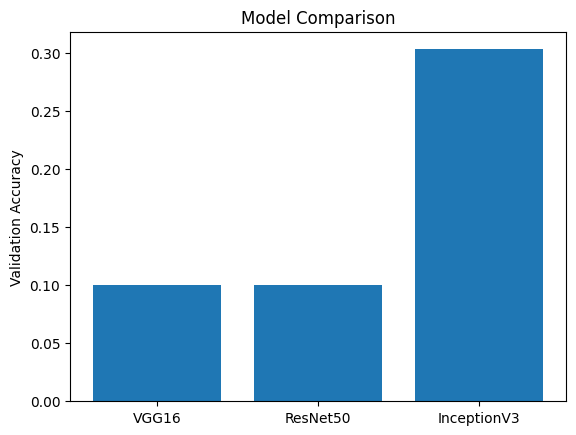

In [ ]:
import matplotlib.pyplot as plt

plt.bar(acc_dict.keys(), acc_dict.values())
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison")
plt.show()

# Observations & Conclusion

In [ ]:
print("Validation Accuracies:")
for name, acc in acc_dict.items():
    print(name, acc)

best_model = max(acc_dict, key=acc_dict.get)
print("\nBest Model:", best_model)

Validation Accuracies:
VGG16 0.10000000149011612
ResNet50 0.10000000149011612
InceptionV3 0.30329999327659607

Best Model: InceptionV3


Colab Link : https://colab.research.google.com/drive/15vuJBgG3FY8jj4Kd60ouX6HELIJ38tE2?usp=sharing